# 2D Burger's LaSDI-NM Example

In [1]:
import os
import time
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy.linalg as LA
from itertools import product
import torch
import torch.nn as nn
import pickle

hypar_dir = os.environ.get('HYPAR_DIR')
hypar_dir_python = hypar_dir + '/Examples/Python'
sys.path.append(hypar_dir_python)

lasdi_dir = os.environ.get('LASDI_DIR')
sys.path.append(lasdi_dir)

import modHyParUtils as hyparutils
import modLaSDIUtils as lasdiutils
import modAutoEncoder as autoencoder
from LaSDI import LaSDI

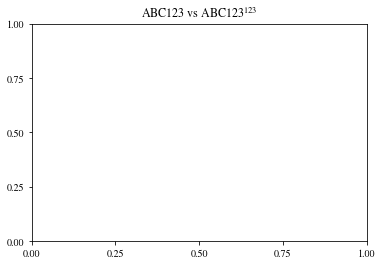

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['figure.dpi'] = 150

In [3]:
!nvidia-smi
torch.cuda.empty_cache()

/usr/bin/sh: 1: nvidia-smi: not found


### Load Necessary simulations and models from Build and Train files.

In [4]:
LS_dim = 3
snapshot_file = './data/snapshot_git.p'
model_file_u = './model/AE_u_git.tar'
model_file_v = './model/AE_v_git.tar'
FOM_file = './data/FOM.p' 

In [5]:
# Set print option
np.set_printoptions(threshold=sys.maxsize)

# Choose device that is not being used
gpu_ids = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')

# Given parameters
nx = 32
ny = 32
m = (ny-2)*(nx-2) # 900
nt = 1000
tstop = 2
dt = tstop/nt
t = np.linspace(0,tstop,nt)

# Choose either Re=10000 or Re=100
Re = 10000 
    
# Choose data normalize option (option 1: -1<=X<=1 option 2: 0<=X<=1)
option = 2

# Choose activation function (sigmoid, swish)
activation = 'sigmoid'

# set the number of nodes in each layer
a = 2
b = int(100)
db = int(10)
M1 = int(a*m) # encoder hidden layer
M2 = b + (m-1)*db # decoder hidden layer

f = LS_dim # latent dimension
mask = lasdiutils.create_mask_2d(nx,ny,m,b,db)

Using device: cpu 

Sparsity in 900 by 9090 mask: 96.56%


In [6]:
encoder_class = autoencoder.Encoder
decoder_class = autoencoder.Decoder
if activation=='sigmoid':
  f_activation = nn.Sigmoid
elif activation=='swish':
  f_activation = autoencoder.SiLU
else:
    raise NameError('{} is given for option, but it must be either sigmoid or swish'.format(activation))


encoder_u, decoder_u = autoencoder.readAEFromFile(  encoder_class,
                                                    decoder_class,
                                                    f_activation,
                                                    mask,
                                                    m, f, M1, M2,
                                                    device,
                                                    model_file_u )

encoder_v, decoder_v = autoencoder.readAEFromFile(  encoder_class,
                                                    decoder_class,
                                                    f_activation,
                                                    mask,
                                                    m, f, M1, M2,
                                                    device,
                                                    model_file_v )

In [7]:
snapshot = pickle.load(open(snapshot_file, 'rb'))

snapshot_u = snapshot['u'].reshape(-1,nx*ny).astype('float32')
snapshot_v = snapshot['v'].reshape(-1,nx*ny).astype('float32')
ndata = snapshot_u.shape[0]

nset = round(ndata/(nt+1))

# remove BC
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

orig_data_u = snapshot_u[:,free_raveled_indicies]
orig_data_v = snapshot_v[:,free_raveled_indicies]

[xv,yv]=np.meshgrid(np.linspace(-3,3,nx),np.linspace(-3,3,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

### Generate Latent-Space Trajectories for Training Data

In [8]:
latent_space_SS_u = autoencoder.encodedSnapshots(encoder_u, orig_data_u, nt+1, device)
latent_space_SS_v = autoencoder.encodedSnapshots(encoder_v, orig_data_u, nt+1, device)

In [9]:
amp_arr = [.75,.85]
width_arr = [.95,1.05]
P = list(product(amp_arr, width_arr))
P = np.array(P)

### Generate LaSDI-NM Models for $U$ and $V$

Dynamical System for U


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.46532e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.46532e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.46532e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


(x0)' = -0.091 1 + 4.116 x0 + 0.533 x1 + -0.476 x2 + 2.917 x0^2 + -9.315 x0 x1 + -3.401 x0 x2 + 1.758 x1^2 + 1.782 x1 x2 + 4.265 x2^2 + -2.240 x0^3 + -1.606 x0^2 x1 + 2.084 x0^2 x2 + 1.984 x0 x1^2 + 2.215 x0 x1 x2 + -1.189 x0 x2^2 + -1.302 x1^3 + -0.972 x1^2 x2 + -4.462 x1 x2^2 + 0.161 x2^3
(x1)' = 0.663 1 + -2.235 x0 + -0.711 x1 + -1.617 x2 + -0.342 x0^2 + 6.918 x0 x1 + 0.274 x0 x2 + -0.571 x1^2 + 0.946 x1 x2 + 1.678 x2^2 + 1.551 x0^3 + -3.518 x0^2 x1 + 1.136 x0^2 x2 + -1.584 x0 x1^2 + -0.730 x0 x1 x2 + 0.125 x0 x2^2 + -0.507 x1^3 + 1.762 x1^2 x2 + -3.110 x1 x2^2 + 0.188 x2^3
(x2)' = -1.782 1 + 4.106 x0 + 3.067 x1 + 3.199 x2 + 7.093 x0^2 + -4.199 x0 x1 + 2.094 x0 x2 + -16.212 x1^2 + -15.046 x1 x2 + -4.100 x2^2 + -3.441 x0^3 + -3.436 x0^2 x1 + -3.529 x0^2 x2 + -0.722 x0 x1^2 + 9.163 x0 x1 x2 + 2.242 x0 x2^2 + 18.669 x1^3 + 4.585 x1^2 x2 + 4.657 x1 x2^2 + -1.041 x2^3

Dynamical System for V


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.16997e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.16997e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.16997e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


(x0)' = 0.901 1 + -0.936 x0 + -6.675 x1 + 1.730 x2 + -1.489 x0^2 + 4.397 x0 x1 + 2.047 x0 x2 + 6.382 x1^2 + 6.059 x1 x2 + -1.366 x2^2 + -1.990 x0^3 + 0.646 x0^2 x1 + 0.378 x0^2 x2 + -2.518 x0 x1^2 + -3.273 x0 x1 x2 + -1.684 x0 x2^2 + -2.002 x1^3 + -4.216 x1^2 x2 + -2.439 x1 x2^2 + -0.049 x2^3
(x1)' = -1.311 1 + 8.338 x0 + 3.924 x1 + 5.692 x2 + 0.358 x0^2 + -10.778 x0 x1 + -7.110 x0 x2 + -0.633 x1^2 + -16.186 x1 x2 + -2.115 x2^2 + -1.597 x0^3 + -5.270 x0^2 x1 + 0.466 x0^2 x2 + 1.897 x0 x1^2 + 4.087 x0 x1 x2 + 1.596 x0 x2^2 + -1.586 x1^3 + 7.979 x1^2 x2 + 5.214 x1 x2^2 + 0.305 x2^3
(x2)' = -0.213 1 + -3.239 x0 + -0.056 x1 + -0.973 x2 + 1.396 x0^2 + 3.519 x0 x1 + 4.530 x0 x2 + 2.173 x1^2 + 4.814 x1 x2 + 2.412 x2^2 + 0.328 x0^3 + 0.134 x0^2 x1 + -1.427 x0^2 x2 + -0.906 x0 x1^2 + -1.787 x0 x1 x2 + -2.141 x0 x2^2 + -1.109 x1^3 + -4.022 x1^2 x2 + -3.583 x1 x2^2 + -2.232 x2^3


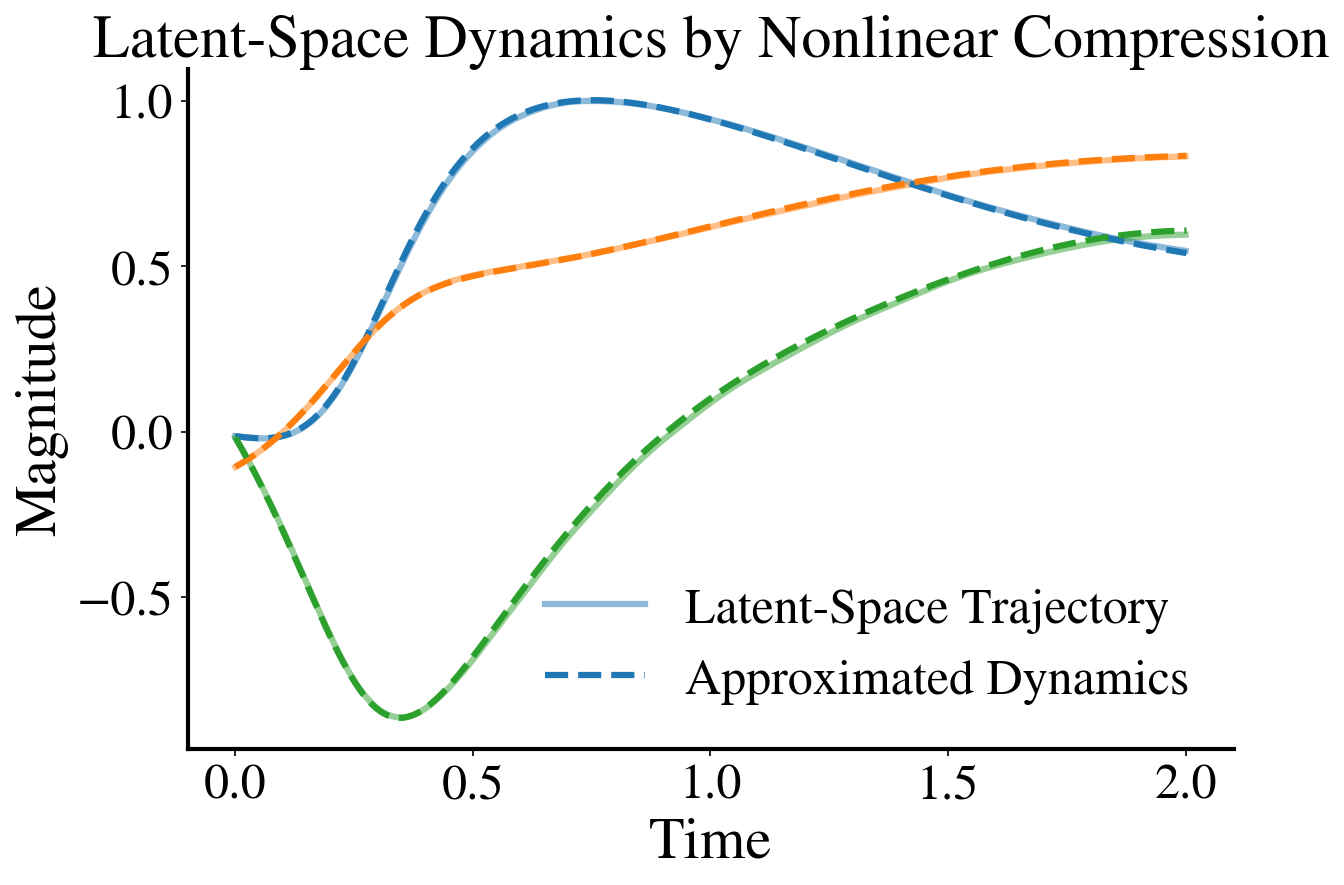

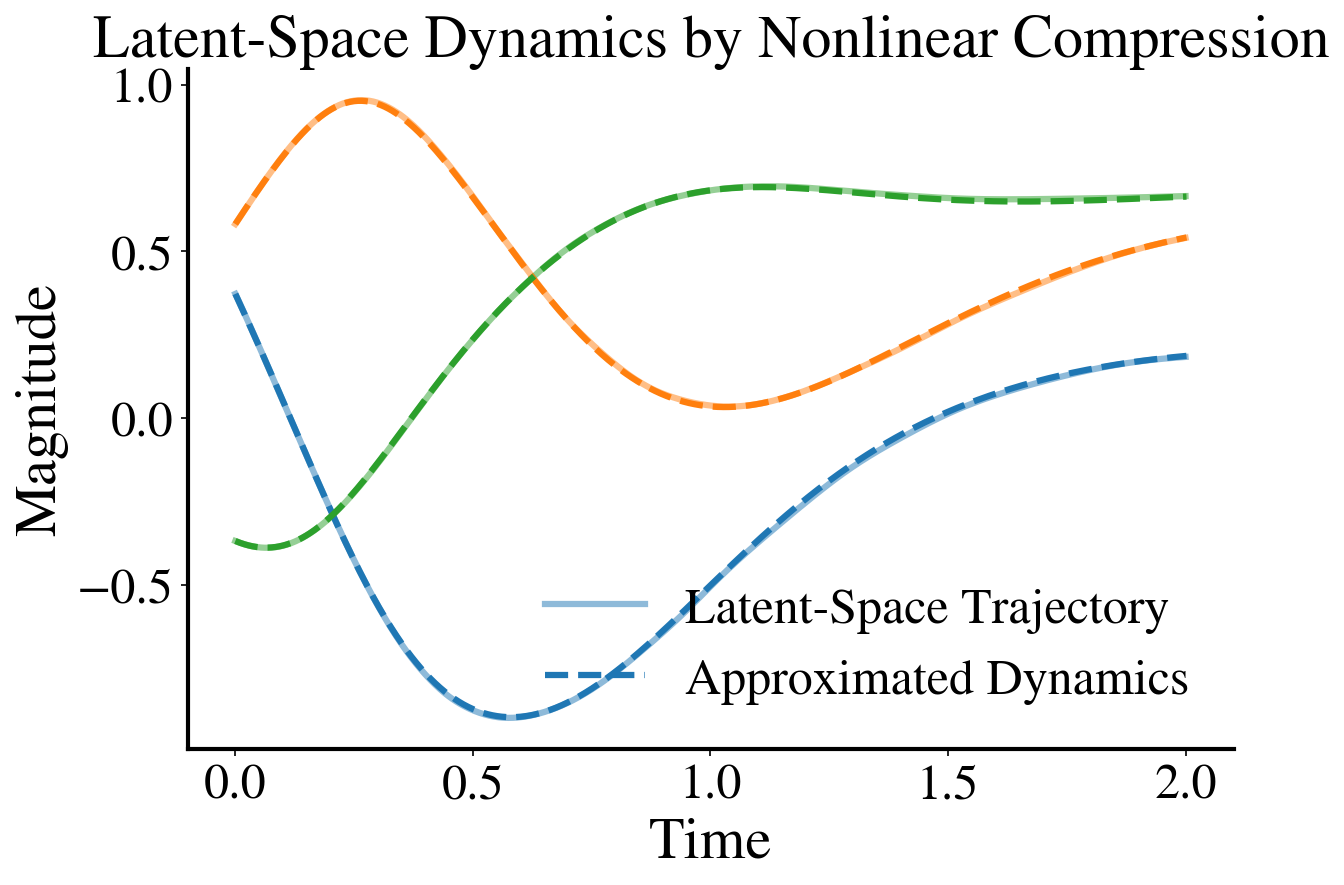

In [10]:
print('Dynamical System for U')
normal_u = np.amax(np.abs(latent_space_SS_u))
LaSDI_model_u = LaSDI(encoder_u, decoder_u, NN = True, device = device)
LaSDI_model_u.train_dynamics(latent_space_SS_u, P, dt, degree = 3, include_interaction = True, normal = normal_u)

print('\nDynamical System for V')
normal_v = np.amax(np.abs(latent_space_SS_v))
LaSDI_model_v = LaSDI(encoder_v, decoder_v, NN = True, device = device)
LaSDI_model_v.train_dynamics(latent_space_SS_v, P, dt, degree = 3, normal = normal_v, include_interaction = True)

## Mapping Parameters to Latent Space

## Interpolation

In [11]:
FOM_high_Re = pickle.load(open(FOM_file,'rb'))
u_full = FOM_high_Re['u']
v_full = FOM_high_Re['v']
time_FOM = FOM_high_Re['t']

u_full = u_full.reshape(-1, nx*ny)
v_full = v_full.reshape(-1,nx*ny)

start = time.time()
FOM_recon_u = LaSDI_model_u.generate_ROM(u_full[0, free_raveled_indicies].astype('float32'), np.array([0.8,1.0]),t)
FOM_recon_v = LaSDI_model_v.generate_ROM(v_full[0, free_raveled_indicies].astype('float32'), np.array([0.8,1.0]),t)
LaSDI_time = time.time()-start

speed_up = time_FOM/LaSDI_time
max_re = np.empty(2)
test = []
for k in range(int(nt)):
    test.append(LA.norm(FOM_recon_u[k].reshape(ny-2,nx-2)-u_full[k,free_raveled_indicies].reshape(ny-2,nx-2))/LA.norm(u_full[k,free_raveled_indicies].reshape(ny-2,nx-2))*100)
max_re[0] = np.amax(test)

test = []
for k in range(int(nt)):
    test.append(LA.norm(FOM_recon_v[k].reshape(ny-2,nx-2)-v_full[k,free_raveled_indicies].reshape(ny-2,nx-2))/LA.norm(v_full[k,free_raveled_indicies].reshape(ny-2,nx-2))*100)
max_re[1] = np.amax(test) 

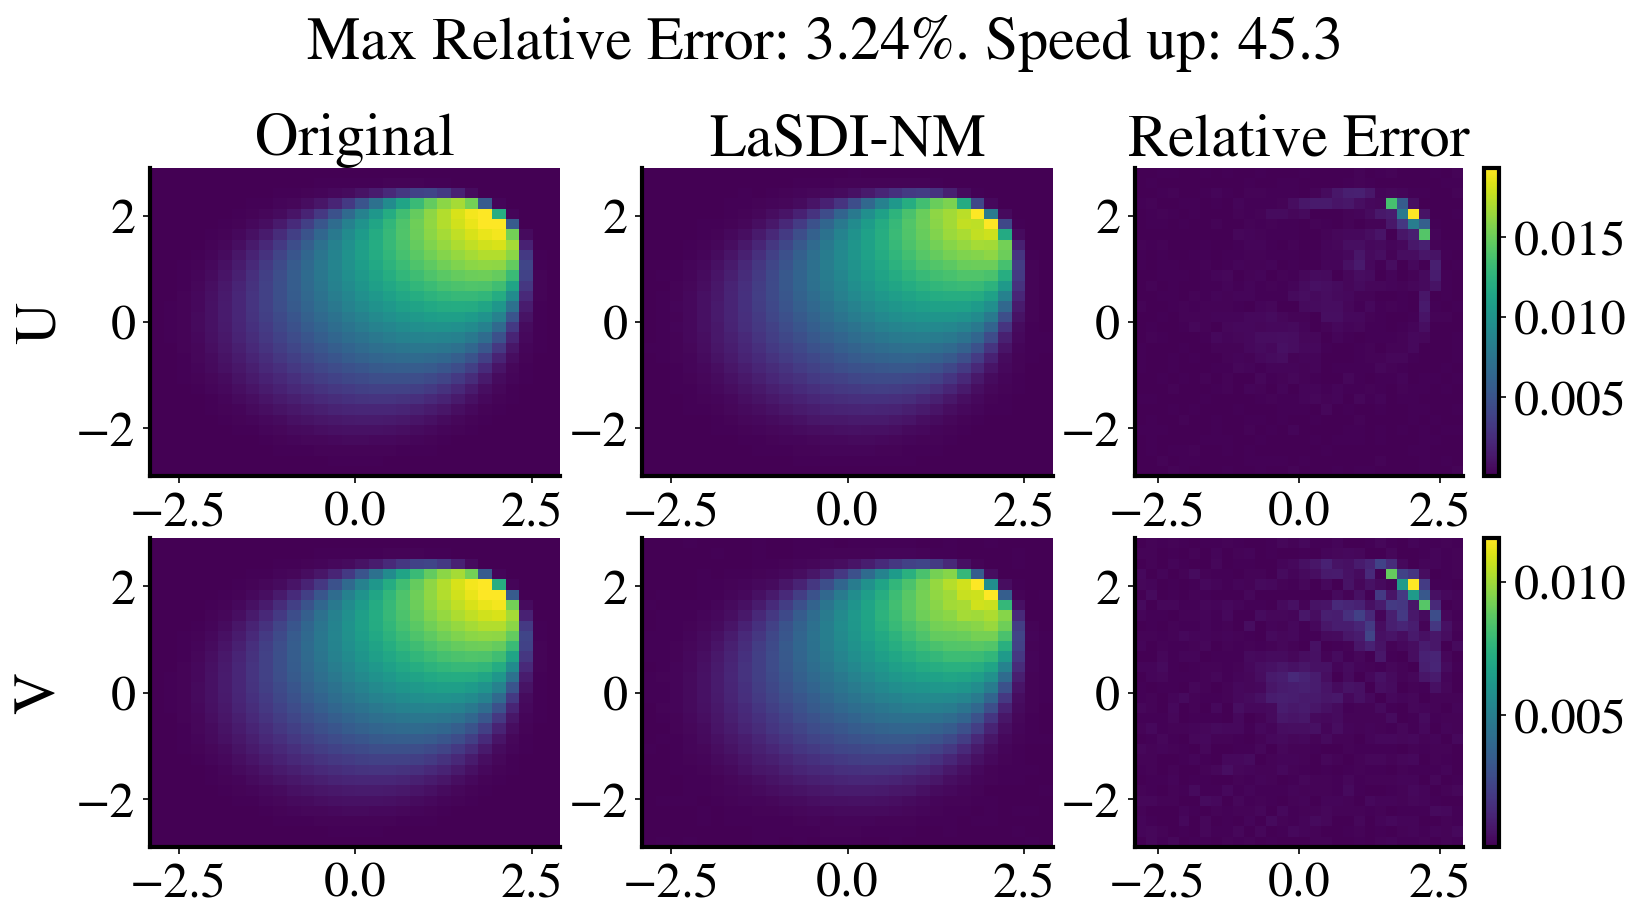

In [12]:
plt.rcParams['figure.dpi'] = 150 
fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
fig.set_size_inches(12,6)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),u_full[k,free_raveled_indicies].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax1)
fig.suptitle('Max Relative Error: {:.2f}%. Speed up: {:.1f}'.format(np.amax(max_re), speed_up), y = 1.05)
ax1.set_title('Original')
ax1.set_ylabel('U')

ax2 = fig.add_subplot(2,3,2)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon_u[k].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax2)
ax2.set_title('LaSDI-NM')

ax3 = fig.add_subplot(2,3,3)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon_u[k].reshape(nx-2,ny-2)-u_full[k,free_raveled_indicies].reshape(nx-2,ny-2))/LA.norm(u_full[k,free_raveled_indicies].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax3)
ax3.set_title('Relative Error')

ax4 = fig.add_subplot(2,3,4)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),v_full[k,free_raveled_indicies].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax4)
ax4.set_ylabel('V')

ax5 = fig.add_subplot(2,3,5)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon_v[k].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax5)

ax6 = fig.add_subplot(2,3,6)
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon_v[k].reshape(nx-2,ny-2)-v_full[k,free_raveled_indicies].reshape(nx-2,ny-2))/LA.norm(v_full[k,free_raveled_indicies].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax6)

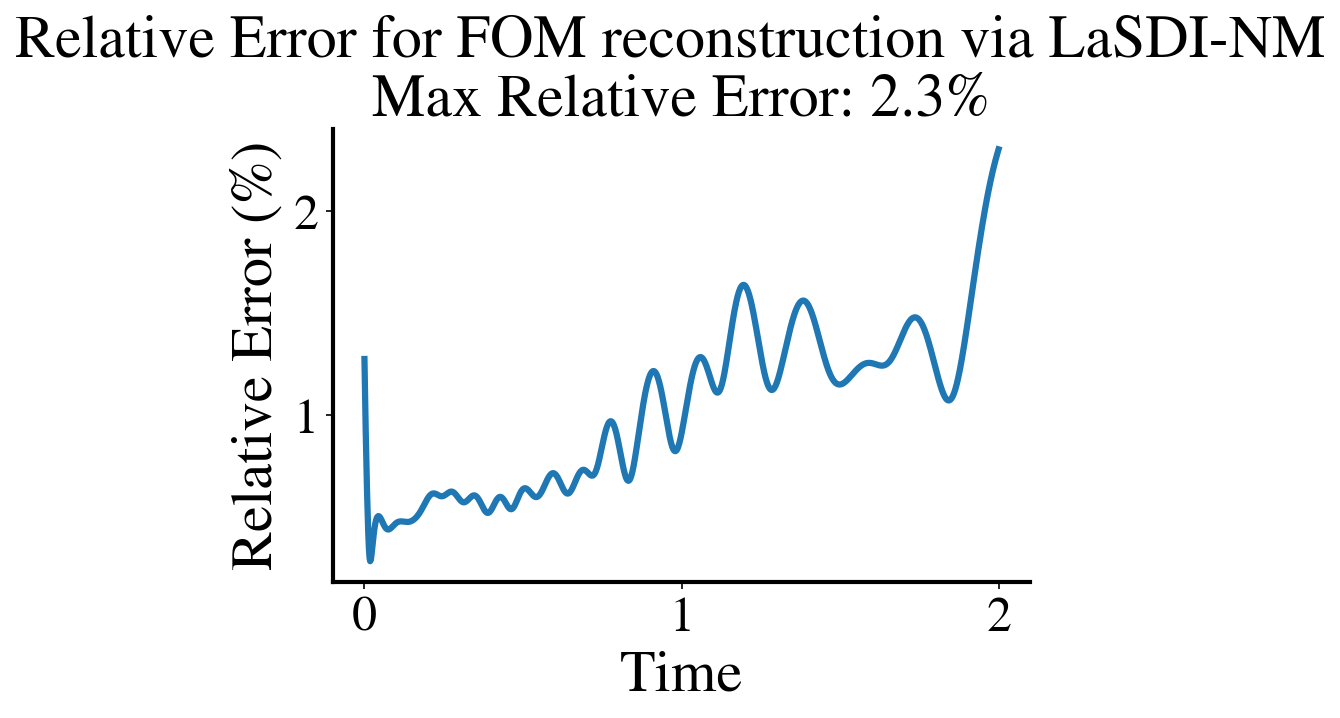

In [13]:
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-NM', y = 1.07)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(test)))
ax.plot(t, test)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
plt.show()